# Model Connectivity Overview
## Setup
### Import packages

In [1]:
from collections import defaultdict
from itertools import permutations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cobra.util.array import create_stoichiometric_matrix
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    get_dirpath,
    read_cobra_model,
    show_versions,
)
from rbc_gem_utils.util import ensure_iterable

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")


model.metabolites.sort()
model.genes.sort()
model.reactions.sort()
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,145eaa510
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
save_figures = True
transparent = False
imagetype = "svg"
dpi = 600
include_boundary_in_calculations = True
results_path = get_dirpath(use_temp="processed") / model.id / "ConnectivityOverview"
results_path.mkdir(exist_ok=True, parents=True)

### Matrix Sparsity

In [4]:
model_sparsity = model.copy()

# Reorder metabolites, first intracellular, then extracellular
cytosol_metabolites = model_sparsity.metabolites.query(lambda x: x.compartment == "c")
extracellular_metabolites = model_sparsity.metabolites.query(
    lambda x: x.compartment == "e"
)
metabolites_ordered = cytosol_metabolites + extracellular_metabolites
assert len(metabolites_ordered) == len(model_sparsity.metabolites)
model_sparsity.metabolites = metabolites_ordered

# Reorder reactions, first intracellular, then transport, finally pseudoreactions
intracellular_reactions = model_sparsity.reactions.query(
    lambda x: not x.boundary and len(model_sparsity.compartments) == 1
)
transport_reactions = model_sparsity.reactions.query(
    lambda x: not x.boundary and len(model_sparsity.compartments) > 1
)
boundary_reactions = model_sparsity.reactions.query(lambda x: x.boundary)
reactions_ordered = intracellular_reactions + transport_reactions + boundary_reactions
assert len(reactions_ordered) == len(model_sparsity.reactions)
model_sparsity.reactions = reactions_ordered
model_sparsity.repair()

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp7bro7srd.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros


Reactions:metabolites (1.52 : 1.00)


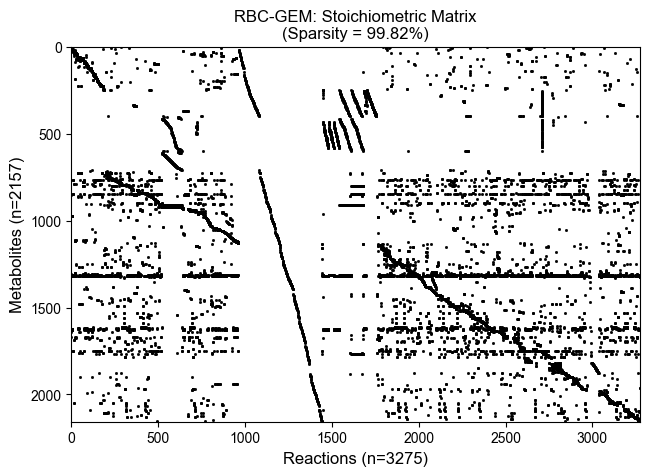

In [5]:
# Ratio of reactions to metabolites currently ~1.4 to 1
print(
    f"Reactions:metabolites ({len(model_sparsity.reactions) / len(model_sparsity.metabolites):.2f} : {len(model_sparsity.metabolites) / len(model_sparsity.metabolites):.2f})"
)

fig, ax = plt.subplots(1, 1, figsize=(1.4 * 4 + 1, 4 + 1))
S = create_stoichiometric_matrix(model, array_type="DataFrame")
if not include_boundary_in_calculations:
    S = S.loc[
        :, model_sparsity.reactions.query(lambda x: not x.boundary).list_attr("id")
    ]
sparsity = 1.0 - (np.count_nonzero(S) / float(S.size))

ax.spy(S, markersize=1, color="black")
ax.set_title(
    f"{model_sparsity.id.replace('_', '-')}: Stoichiometric Matrix\n(Sparsity = {sparsity*100:.2f}%)",
    fontsize=12,
)
ax.set_xlabel(f"Reactions (n={len(model_sparsity.reactions)})", fontsize=12)
ax.set_ylabel(f"Metabolites (n={len(model_sparsity.metabolites)})", fontsize=12)
ax.xaxis.set_ticks_position("bottom")
metabolite_indicies = dict(
    zip(
        list(range(1 + len(model_sparsity.metabolites.list_attr("id")) + 2)),
        model_sparsity.metabolites.list_attr("id"),
    )
)
metabolite_indicies = pd.DataFrame.from_dict(
    dict(
        zip(
            list(range(1 + len(model_sparsity.metabolites.list_attr("id")) + 2)),
            model_sparsity.metabolites.list_attr("id"),
        )
    ),
    orient="index",
    columns=["metabolites"],
)


reaction_indicies = dict(
    zip(
        list(range(1 + len(model_sparsity.reactions.list_attr("id")) + 2)),
        model_sparsity.reactions.list_attr("id"),
    )
)
reaction_indicies = pd.DataFrame.from_dict(
    dict(
        zip(
            list(range(1 + len(model_sparsity.reactions.list_attr("id")) + 2)),
            model_sparsity.reactions.list_attr("id"),
        )
    ),
    orient="index",
    columns=["reactions"],
)
fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"MatrixSparsity_{model.id}.{imagetype}",
        transparent=transparent,
    )

### Calculate connectivities

In [6]:
table_data = {}

In [7]:
def compute_connectivities(
    model,
    attribute_type="metabolites",
    compartments=None,
    exclude=None,
    sum_compartments=False,
    aggregate_ranking=False,
    include_boundary=False,
):
    """Compute the metabolite connectivities of the model.

    Parameters
    ----------
    model : Model
        The model object
    attribute_type : {"metabolites", "genes"}
        The type of object.
    compartments : list, None
        Compartments that should be accounted for. If ``None``, all metabolite compartments are utilized.
    exclude : iterable
        Contains identifiers for metabolites that should be excluded from calculations.
        Useful for excluding currency metabolites (e.g., hydrogen, water) from calculations.
    sum_compartments : bool
        Whether to treat the metabolite as one entity and sum metabolite connectivities across compartments.
        If True, the connectivity is determined without regard to the species compartment.
        If False, the connectivity is determined seperately for species in different compartments.
    aggregate_ranking : bool
        If True, metabolites that have the same connectivity value are grouped together.
        If False, metabolites are kept seperately.
    include_boundary : bool
        If True, pseudoreactions are included in the connectivity count.
        If False, metabolites are kept seperately.
    """
    if not include_boundary:
        # Copy model and remove boundaries
        model = model.copy()
        model.remove_groups([model.groups.get_by_id("Pseudoreactions")])
        model.remove_reactions(model.boundary)
    species = getattr(model, attribute_type)
    # Get compartments
    if compartments:
        compartments = ensure_iterable(compartments)
    else:
        compartments = sorted(model.compartments)

    # Exclude metabolites
    if exclude is None:
        exclude = set()
    else:
        exclude = {str(x) for x in ensure_iterable(exclude)}

    if attribute_type == "metabolites":
        species = species.query(
            lambda x: (
                (
                    not x.id.replace(f"_{x.compartment}", "") in exclude
                    and not x.id in exclude
                )
                if sum_compartments
                else (not x.id in exclude)
            )
        )
        species = species.query(lambda x: x.compartment in set(compartments))
    else:
        species = species.query(lambda x: not x.id in exclude)

    # Compute absolute connectivities
    absolute_connectivities = defaultdict(int)
    absolute_connectivities = pd.Series(
        {specie.id: len(specie.reactions) for specie in species}, name="absolute"
    ).sort_values(ascending=False)
    absolute_connectivities.index.name = attribute_type

    if sum_compartments and attribute_type == "metabolites":
        # Aggregate metabolites across compartments and sum
        absolute_connectivities = absolute_connectivities.rename(
            {
                sid: sid.replace(f"_{species.get_by_id(sid).compartment}", "")
                for sid in absolute_connectivities.index
            },
            axis=0,
        )
        absolute_connectivities = absolute_connectivities.groupby(
            absolute_connectivities.index
        ).sum()

    # Compute relative connectivities
    relative_connectivities = absolute_connectivities / absolute_connectivities.sum()
    relative_connectivities.name = "relative"
    # Create DataFrame
    df_connectivity = pd.merge(
        absolute_connectivities,
        relative_connectivities,
        left_index=True,
        right_index=True,
    )
    df_connectivity = df_connectivity.reset_index(drop=False)
    df_connectivity = df_connectivity.sort_values(
        ["absolute", attribute_type], ascending=False
    )

    if aggregate_ranking:
        # Aggregate metabolites that share the same ranking
        df_connectivity = (
            df_connectivity.groupby(["absolute", "relative"], as_index=False)
            .agg(lambda x: set(x))
            .sort_index(ascending=False)
        )
    # Reset index, reorganize columns, and return
    df_connectivity = df_connectivity.reset_index(drop=True).loc[
        :, [attribute_type, "absolute", "relative"]
    ]
    return df_connectivity

#### Metabolite connectivity

In [8]:
num_display = 15
sum_compartments = True
aggregate_ranking = False
include_boundary = False
exclude_list = []
attribute_type = "metabolites"

compartments = ["e"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["e"]], df_connectivity.columns]
)
df_connectivity_e = df_connectivity.copy()

compartments = ["c"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["c"]], df_connectivity.columns]
)
df_connectivity_c = df_connectivity.copy()

df_metabolite_connectivity_table = pd.merge(
    df_connectivity_c,
    df_connectivity_e,
    left_index=True,
    right_index=True,
    how="outer",
)

compartments = None
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [["total"], df_connectivity.columns]
)
df_connectivity_all = df_connectivity.copy()

df_metabolite_connectivity_table = (
    pd.merge(
        df_connectivity_all,
        df_metabolite_connectivity_table,
        left_index=True,
        right_index=True,
        how="outer",
    )
    .fillna(0)
    .sort_values(by=("total", "absolute"), ascending=False)
)
for col in df_metabolite_connectivity_table.columns:
    if col[1] == "absolute":
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(int)
    else:
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(float)
table_data[attribute_type] = df_metabolite_connectivity_table.copy()
df_metabolite_connectivity_table.head(num_display)

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpi4ipxlsf.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp3dfxgy2i.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp3655v_mk.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros


total            cytosol           extracellular space  \
            absolute  relative absolute  relative            absolute   
metabolites                                                             
h               1035  0.087070      974  0.095415                  61   
h2o              811  0.068226      783  0.076705                  28   
na1              326  0.027425      163  0.015968                 163   
atp              311  0.026163      308  0.030172                   3   
coa              278  0.023387      278  0.027234                   0   
pi               241  0.020274      229  0.022433                  12   
nadp             210  0.017666      208  0.020376                   2   
nadph            209  0.017582      209  0.020474                   0   
adp              204  0.017162      201  0.019690                   3   
ppi              148  0.012451      147  0.014400                   1   
amp              125  0.010516      123  0.012049                   2   
nad              122  0.010263      119  0.011658                   3   
nadh             117  0.009843      117  0.011462                   0   
crn              117  0.009843      115  0.011266                   2   
o2               111  0.009338      106  0.010384                   5   

                       
             relative  
metabolites            
h            0.036331  
h2o          0.016677  
na1          0.097082  
atp          0.001787  
coa          0.000000  
pi           0.007147  
nadp         0.001191  
nadph        0.000000  
adp          0.001787  
ppi          0.000596  
amp          0.001191  
nad          0.001787  
nadh         0.000000  
crn          0.001191  
o2           0.002978

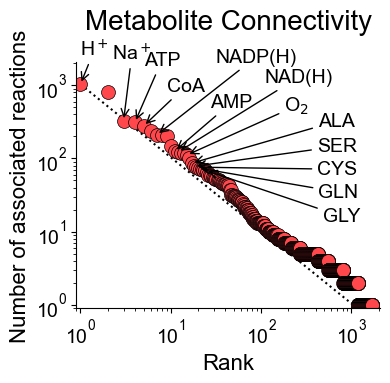

In [9]:
df_connectivity = df_metabolite_connectivity_table["total"].reset_index(drop=False)


key = "absolute"
scale_points = False
color = "xkcd:light red"
refline_color = "black"

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.despine(fig)


ax.scatter(
    df_connectivity[key].index + 1,  # Log plots do not do well with index of 0.
    df_connectivity[key].values,
    marker="o",
    edgecolors="black",
    lw=0.5,
    # linestyle="",
    color=color,
    s=df_connectivity["relative"].values * 10000 if scale_points else 100,
    zorder=2,
    label=model.id.replace("_", "-"),
)
# A reference line, linking the minimum and maximum connectivities
ax.loglog(
    [df_connectivity[key].max(), df_connectivity[key].min()],
    [df_connectivity[key].min(), df_connectivity[key].max()],
    zorder=1,
    color=refline_color,
    linestyle=":",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Metabolite Connectivity", fontdict={"size": 20}, y=1.1)
ax.set_xlabel("Rank", fontdict={"size": 16})
ax.set_ylabel("Number of associated reactions", fontdict={"size": 16})
ax.set_xlim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_ylim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_xticks([1e0, 1e1, 1e2, 1e3])
ax.set_yticks([1e0, 1e1, 1e2, 1e3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)


mets_to_labels = {
    # Name, xscalar, yscalar
    "h": ("H$^+$", 1, 2.5),
    "na1": ("Na$^+$", 0.75, 7),
    "atp": ("ATP", 1.25, 6),
    "amp": ("AMP", 2.5, 4),
    "nadp": ("NADP(H)", 4.5, 10),
    "nad": ("NAD(H)", 9, 9),
    "coa": ("CoA", 1.8, 3),
    "o2": ("O$_2$", 12, 4),
    "ala__L": ("ALA", 25, 3.2),
    "ser__L": ("SER", 23, 1.6),
    "cys__L": ("CYS", 22, 0.8),
    "gln__L": ("GLN", 21.5, 0.4),
    "gly": ("GLY", 20, 0.2),
}
for i, row in df_connectivity[
    df_connectivity["metabolites"].isin(list(mets_to_labels))
].iterrows():
    x = i + 1
    met, y = row[["metabolites", "absolute"]].values
    name, xscalar, yscalar = mets_to_labels[met]
    ax.annotate(
        xy=(x, y),
        xytext=(x * xscalar, y * yscalar),
        text=name,
        xycoords="data",
        fontsize=14,
        arrowprops=dict(arrowstyle="->"),
    )

fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"{attribute_type}_connectivity_{model.id}.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else 600,
    )

### Gene connectivity

In [10]:
num_display = 15
compartments = None
sum_compartments = True
aggregate_ranking = False
include_boundary = False
exclude_list = []
attribute_type = "genes"


df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
table_data[attribute_type] = df_connectivity.copy()
df_connectivity.iloc[num_display : num_display * 2].head(num_display)

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpsgnv_20j.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros


,genes,absolute,relative
15,ACSL3,59,0.012137
16,ACSL1,59,0.012137
17,ABCC4,52,0.010697
18,PRDX6,51,0.010492
19,ACOT7,41,0.008434
20,FASN,38,0.007817
21,MBLAC2,37,0.007612
22,HSD17B12,33,0.006789
23,HBZ,33,0.006789
24,HBQ1,33,0.006789


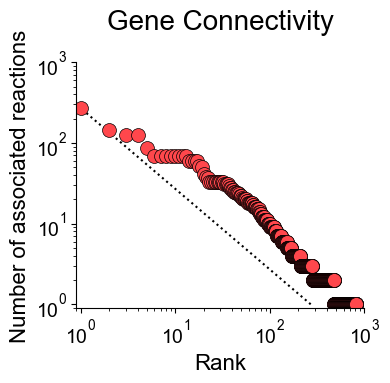

In [11]:
key = "absolute"
scale_points = False
color = "xkcd:light red"
refline_color = "black"

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.despine(fig)


ax.scatter(
    df_connectivity[key].index + 1,  # Log plots do not do well with index of 0.
    df_connectivity[key].values,
    marker="o",
    edgecolors="black",
    lw=0.5,
    # linestyle="",
    color=color,
    s=df_connectivity["relative"].values * 10000 if scale_points else 100,
    zorder=2,
    label=model.id.replace("_", "-"),
)
# A reference line, linking the minimum and maximum connectivities
ax.loglog(
    [df_connectivity[key].max(), df_connectivity[key].min()],
    [df_connectivity[key].min(), df_connectivity[key].max()],
    zorder=1,
    color=refline_color,
    linestyle=":",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title("Gene Connectivity", fontdict={"size": 20}, y=1.1)
ax.set_xlabel("Rank", fontdict={"size": 16})
ax.set_ylabel("Number of associated reactions", fontdict={"size": 16})
ax.set_xlim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_ylim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_xticks([1e0, 1e1, 1e2, 1e3])
ax.set_yticks([1e0, 1e1, 1e2, 1e3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"{attribute_type}_connectivity_{model.id}.{imagetype}",
        transparent=transparent,
    )

In [12]:
print(list(table_data.keys()))
if save_figures:
    with pd.ExcelWriter(
        results_path / f"ModelConnectivity_{model.id}.xlsx",
    ) as writer:
        for sheet_name, df in table_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=True)

['metabolites', 'genes']


#### Calculate connectivities with exclusion of currency/common hub metabolites

In [13]:
def get_primary_reactions(model, metabolite_set):
    """Return the primary reactions for a set of metabolites.

    Used to help determine reactions which reactions treat cofactors as a primary or secondary metabolite product.
    """
    primary_reactions = set()
    for combo in permutations(list(metabolite_set), 2):
        main_met = model.metabolites.get_by_id(combo[0])
        for other_met in combo[1:]:
            other_met = model.metabolites.get_by_id(other_met)
            for reaction in main_met.reactions:
                if not reaction in other_met.reactions:
                    primary_reactions.add(reaction.id)
    return primary_reactions


def remove_metabolites_from_reactions(model, metabolite_set, exclusion_list):
    """Helper method to remove metabolites from reactions."""
    new_model = model.copy()
    for metabolite in list(metabolite_set):
        metabolite = new_model.metabolites.get_by_id(metabolite)
        for reaction in metabolite.reactions:
            reaction = new_model.reactions.get_by_id(reaction.id)
            if reaction.id in exclusion_list:
                continue
            reaction.add_metabolites({metabolite: 0}, combine=False)

    new_model.repair()
    return new_model

In [14]:
mets_to_exclude = [
    "h",
    "oh1",
    "h2o",
    "k",
    "na1",
    "cl",
    "ag1",
    "ca2",
    "cd2",
    "cobalt2",
    "cu1",
    "cu2",
    "fe2",
    "fe3",
    "mg2",
    "mn2",
    "zn2",
    "i",
    "o2",
    "o2s",
    "co2",
    "h2o2",
    "nh4",
    "nh3",
    "pi",
    "ppi",
    "so4",
    "so3",
    "coa",
    "hco3",
]
model_excluded_mets = model.copy()
for compartment in ["c", "e"]:
    for metabolite_set in [
        # Common Redox pairs
        # NADH <=> NAD
        # NADPH <=> NADP
        # 2 GTHRD <=> GTHOX
        ["nadh", "nad"],
        ["nadph", "nadp"],
        ["gthrd", "gthox"],
    ]:
        metabolite_set = [f"{met}_{compartment}" for met in metabolite_set]
        try:
            exclude_from_changes = get_primary_reactions(
                model_excluded_mets, metabolite_set
            )
            model_excluded_mets = remove_metabolites_from_reactions(
                model_excluded_mets, metabolite_set, exclude_from_changes
            )
        except KeyError:
            print(f"Not all metabolites present for {metabolite_set}")

for compartment in ["c", "e"]:
    for metabolite_set in [
        # Coupled to hydrolysis of ATP
        # ATP --> AMP + PPi
        # ATP --> ADP + Pi
        # ATP --> ADP
        ["atp", "amp", "ppi"],
        ["atp", "adp", "pi"],
        ["atp", "adp"],
    ]:
        metabolite_set = [f"{met}_{compartment}" for met in metabolite_set]
        try:
            exclude_from_changes = get_primary_reactions(
                model_excluded_mets, metabolite_set
            )

            exclude_from_changes.update(
                [
                    "ADK1",  # Needs manual correction
                    "AP5AH1",  # Should not be corrected
                ]
            )
            model_excluded_mets = remove_metabolites_from_reactions(
                model_excluded_mets, metabolite_set, exclude_from_changes
            )
        except KeyError:
            print(f"Not all metabolites present for {metabolite_set}")
# Remove secondary ATP --> ADP coupled to transformation
model_excluded_mets.reactions.ADK1.build_reaction_from_string("amp_c <=> adp_c")
for compartment in ["c", "e"]:
    model_excluded_mets.remove_metabolites(
        [
            model_excluded_mets.metabolites.get_by_id(f"{met}_{compartment}")
            for met in mets_to_exclude
            if model_excluded_mets.metabolites.has_id(f"{met}_{compartment}")
        ],
        destructive=False,
    )

model_excluded_mets.remove_reactions(
    model_excluded_mets.reactions.query(lambda x: len(x.metabolites) == 0)
)
model_excluded_mets.remove_metabolites(
    model_excluded_mets.metabolites.query(lambda x: len(x.reactions) == 0)
)
model_excluded_mets.metabolites.sort()
model_excluded_mets.genes.sort()
model_excluded_mets.reactions.sort()
model_excluded_mets.groups.sort()
model_excluded_mets.repair()
model_excluded_mets

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpqapdes0d.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpxgzu3bgr.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24874 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp197o4oti.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 24426 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpwpyzqxhk.lp
Reading time = 0.02 seconds
: 2157 rows, 6550 columns, 23606 nonzeros
Not all metabolites present for ['nadh_e', 'nad_e']
Not all metabolites present for ['nadph_e', 'nadp_e']
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp8h4_j08z.lp
Reading time = 0.01 seconds
: 2157 rows, 6550 columns, 23434 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsr

/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Name,RBC_GEM
Memory address,150cd0c50
Number of metabolites,2099
Number of reactions,3165
Number of genes,820
Number of groups,78
Objective expression,0
Compartments,"cytosol, extracellular space"


In [15]:
for met in sorted(mets_to_exclude):
    print(model.metabolites.get_by_id(f"{met}_c").name)

Silver (I)
Calcium
Cadmium (II)
Chloride
CO2
Coenzyme A
Cobalt (II)
Copper (I)
Cu2+
Iron (II)
Iron (III)
H+
H2O
H2O2
Bicarbonate
Iodide
K+
Magnesium (II)
Manganese (II)
Sodium
Ammonia
Ammonium
O2 
Superoxide
Hydroxide
Orthophosphate
Diphosphate
Sulfite
Sulfate
Zinc (II)


In [16]:
num_display = 15
sum_compartments = True
aggregate_ranking = False
include_boundary = False
attribute_type = "metabolites"
exclude_list = []

model = model_excluded_mets.copy()
compartments = ["e"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["e"]], df_connectivity.columns]
)
df_connectivity_e = df_connectivity.copy()

compartments = ["c"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["c"]], df_connectivity.columns]
)
df_connectivity_c = df_connectivity.copy()

df_metabolite_connectivity_table = pd.merge(
    df_connectivity_c,
    df_connectivity_e,
    left_index=True,
    right_index=True,
    how="outer",
)

compartments = None
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [["total"], df_connectivity.columns]
)
df_connectivity_all = df_connectivity.copy()

df_metabolite_connectivity_table = (
    pd.merge(
        df_connectivity_all,
        df_metabolite_connectivity_table,
        left_index=True,
        right_index=True,
        how="outer",
    )
    .fillna(0)
    .sort_values(by=("total", "absolute"), ascending=False)
)
for col in df_metabolite_connectivity_table.columns:
    if col[1] == "absolute":
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(int)
    else:
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(float)

table_data[f"{attribute_type}-con-exclude"] = df_metabolite_connectivity_table.copy()
df_metabolite_connectivity_table.head(num_display)

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpxuelczfu.lp
Reading time = 0.01 seconds
: 2099 rows, 6330 columns, 15446 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpphe3n1y7.lp
Reading time = 0.01 seconds
: 2099 rows, 6330 columns, 15446 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpn4m9wo6k.lp
Reading time = 0.01 seconds
: 2099 rows, 6330 columns, 15446 nonzeros


/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpk_yznkja.lp
Reading time = 0.01 seconds
: 2099 rows, 6330 columns, 15446 nonzeros


/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


total            cytosol           extracellular space  \
            absolute  relative absolute  relative            absolute   
metabolites                                                             
crn              117  0.016261      115  0.019413                   2   
ala__L            86  0.011953       46  0.007765                  40   
ser__L            78  0.010841       43  0.007259                  35   
cys__L            76  0.010563       46  0.007765                  30   
gln__L            74  0.010285       42  0.007090                  32   
thr__L            71  0.009868       37  0.006246                  34   
gly               69  0.009590       44  0.007427                  25   
asn__L            66  0.009173       34  0.005739                  32   
pro__L            60  0.008339       36  0.006077                  24   
leu__L            59  0.008200       36  0.006077                  23   
gthrd             58  0.008061       50  0.008440                   8   
phe__L            57  0.007922       34  0.005739                  23   
arg__L            56  0.007783       32  0.005402                  24   
avite1r           54  0.007505       54  0.009115                   0   
met__L            53  0.007366       31  0.005233                  22   

                       
             relative  
metabolites            
crn          0.001574  
ala__L       0.031471  
ser__L       0.027537  
cys__L       0.023603  
gln__L       0.025177  
thr__L       0.026751  
gly          0.019670  
asn__L       0.025177  
pro__L       0.018883  
leu__L       0.018096  
gthrd        0.006294  
phe__L       0.018096  
arg__L       0.018883  
avite1r      0.000000  
met__L       0.017309

In [17]:
table_data["MetConnectivityExclusions"] = df_metabolite_connectivity_table.copy()
table_data["MetConnectivityExclusions"]

total            cytosol            \
                        absolute  relative absolute  relative   
metabolites                                                     
crn                          117  0.016261      115  0.019413   
ala__L                        86  0.011953       46  0.007765   
ser__L                        78  0.010841       43  0.007259   
cys__L                        76  0.010563       46  0.007765   
gln__L                        74  0.010285       42  0.007090   
...                          ...       ...      ...       ...   
glcr                           1  0.000139        1  0.000169   
FAcoa_hs_16_7E10Z3OH__S        1  0.000139        1  0.000169   
zymstnl                        1  0.000139        1  0.000169   
clho                           0  0.000000        0  0.000000   
fe3ooh                         0  0.000000        0  0.000000   

                        extracellular space            
                                   absolute  relative  
metabolites                                            
crn                                       2  0.001574  
ala__L                                   40  0.031471  
ser__L                                   35  0.027537  
cys__L                                   30  0.023603  
gln__L                                   32  0.025177  
...                                     ...       ...  
glcr                                      0  0.000000  
FAcoa_hs_16_7E10Z3OH__S                   0  0.000000  
zymstnl                                   0  0.000000  
clho                                      0  0.000000  
fe3ooh                                    0  0.000000  

[1655 rows x 6 columns]

##### Visualize

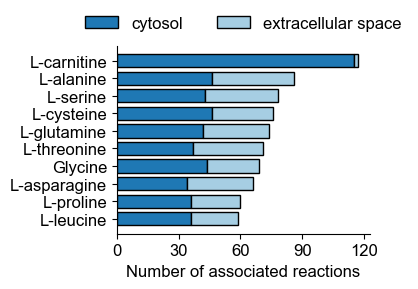

In [18]:
df = pd.concat(
    (
        df_metabolite_connectivity_table["cytosol"]["absolute"],
        df_metabolite_connectivity_table["extracellular space"]["absolute"],
    ),
    axis=1,
).head(10)
df.columns = ["cytosol", "extracellular space"]


columns_to_plot = ["cytosol", "extracellular space"]
df = df[columns_to_plot].copy()
colormaps_dict = {
    columns_to_plot[0]: mpl.colormaps["Paired"](1),
    columns_to_plot[1]: mpl.colormaps["Paired"](0),
}

mets_map = {
    "crn": "L-carnitine",
    "ala__L": "L-alanine",
    "ser__L": "L-serine",
    "cys__L": "L-cysteine",
    "gln__L": "L-glutamine",
    "thr__L": "L-threonine",
    "gly": "Glycine",
    "asn__L": "L-asparagine",
    "pro__L": "L-proline",
    "leu__L": "L-leucine",
}
df.index = [mets_map[met] for met in df.index]


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.despine(fig)

barsize = 0.75
edgecolor = "black"
edgewidth = 1
padding = 2
offset = np.zeros(len(df.index))
df.index = df.index.astype(str)
df = df.loc[df.index[::-1]]
for idx, (label, series) in enumerate(df.items()):
    rects = ax.barh(
        series.index,
        series.values,
        height=barsize,
        left=offset,
        color=colormaps_dict.get(label),
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")

ax.set_xlabel("Number of associated reactions", fontdict={"size": "large"})
ax.set_xticks([0, 30, 60, 90, 120])

ax.legend(
    handles=[
        mpl.patches.Patch(facecolor=color, edgecolor=edgecolor)
        for color in list(colormaps_dict.values())
    ],
    labels=list(colormaps_dict.keys()),
    frameon=False,
    bbox_to_anchor=(0.5, 1),
    loc="lower center",
    ncol=2,
    fontsize="large",
)
fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"Top10_w_transporter.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else dpi,
    )

#### Calculate connectivities for intracellular network only

In [19]:
model_excluded_transports = model_excluded_mets.copy()
model_excluded_transports.remove_reactions(
    [
        reaction
        for reaction in model_excluded_transports.reactions
        if reaction.compartments != {"c"}
    ]
)

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp6zc_xmtp.lp
Reading time = 0.01 seconds
: 2099 rows, 6330 columns, 15446 nonzeros


/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [20]:
num_display = 15
sum_compartments = True
aggregate_ranking = False
include_boundary = False
attribute_type = "metabolites"
exclude_list = []

model = model_excluded_transports.copy()
compartments = ["e"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["e"]], df_connectivity.columns]
)
df_connectivity_e = df_connectivity.copy()

compartments = ["c"]
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [[model.compartments["c"]], df_connectivity.columns]
)
df_connectivity_c = df_connectivity.copy()

df_metabolite_connectivity_table = pd.merge(
    df_connectivity_c,
    df_connectivity_e,
    left_index=True,
    right_index=True,
    how="outer",
)

compartments = None
df_connectivity = compute_connectivities(
    model,
    attribute_type=attribute_type,
    compartments=compartments,
    exclude=exclude_list,
    sum_compartments=sum_compartments,
    aggregate_ranking=aggregate_ranking,
)
df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
    lambda x: build_string(x, sep=", ")
)
# table_data[attribute_type] = df_connectivity
df_connectivity = df_connectivity.set_index("metabolites")
df_connectivity.columns = pd.MultiIndex.from_product(
    [["total"], df_connectivity.columns]
)
df_connectivity_all = df_connectivity.copy()

df_metabolite_connectivity_table = (
    pd.merge(
        df_connectivity_all,
        df_metabolite_connectivity_table,
        left_index=True,
        right_index=True,
        how="outer",
    )
    .fillna(0)
    .sort_values(by=("total", "absolute"), ascending=False)
)
for col in df_metabolite_connectivity_table.columns:
    if col[1] == "absolute":
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(int)
    else:
        df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
            col
        ].astype(float)


table_data[f"{attribute_type}-con-exclude_no_tpt"] = (
    df_metabolite_connectivity_table.copy()
)
df_metabolite_connectivity_table.head(num_display)

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmphv73o6d1.lp
Reading time = 0.01 seconds
: 2099 rows, 3710 columns, 9640 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpfr7n0m3q.lp
Reading time = 0.01 seconds
: 2099 rows, 3710 columns, 9640 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpy8so8oos.lp
Reading time = 0.01 seconds
: 2099 rows, 3710 columns, 9640 nonzeros


/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmp1ez734gd.lp
Reading time = 0.01 seconds
: 2099 rows, 3710 columns, 9640 nonzeros


/Users/zhaiman/opt/miniconda3/envs/memote-rbc-gem/lib/python3.11/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


total            cytosol            \
                             absolute  relative absolute  relative   
metabolites                                                          
crn                               113  0.023805      113  0.023805   
avite1r                            54  0.011376       54  0.011376   
gthrd                              42  0.008848       42  0.008848   
amet__L                            31  0.006530       31  0.006530   
ahcys__L                           30  0.006320       30  0.006320   
avite1                             29  0.006109       29  0.006109   
udp                                27  0.005688       27  0.005688   
amp                                26  0.005477       26  0.005477   
avite1qn                           25  0.005266       25  0.005266   
glu__L                             25  0.005266       25  0.005266   
FA_hs                              21  0.004424       21  0.004424   
FA_hs_22_4Z7Z10Z13Z16Z19Zroo       21  0.004424       21  0.004424   
gdp                                20  0.004213       20  0.004213   
akg                                20  0.004213       20  0.004213   
gly                                19  0.004003       19  0.004003   

                             extracellular space           
                                        absolute relative  
metabolites                                                
crn                                            0      0.0  
avite1r                                        0      0.0  
gthrd                                          0      0.0  
amet__L                                        0      0.0  
ahcys__L                                       0      0.0  
avite1                                         0      0.0  
udp                                            0      0.0  
amp                                            0      0.0  
avite1qn                                       0      0.0  
glu__L                                         0      0.0  
FA_hs                                          0      0.0  
FA_hs_22_4Z7Z10Z13Z16Z19Zroo                   0      0.0  
gdp                                            0      0.0  
akg                                            0      0.0  
gly                                            0      0.0

In [21]:
table_data["MetConnectivityNoTransport"] = df_metabolite_connectivity_table.copy()
table_data["MetConnectivityNoTransport"]

total            cytosol           extracellular space         
            absolute  relative absolute  relative            absolute relative
metabolites                                                                   
crn              113  0.023805      113  0.023805                   0      0.0
avite1r           54  0.011376       54  0.011376                   0      0.0
gthrd             42  0.008848       42  0.008848                   0      0.0
amet__L           31  0.006530       31  0.006530                   0      0.0
ahcys__L          30  0.006320       30  0.006320                   0      0.0
...              ...       ...      ...       ...                 ...      ...
tudchola           0  0.000000        0  0.000000                   0      0.0
mmarg__L           0  0.000000        0  0.000000                   0      0.0
mma                0  0.000000        0  0.000000                   0      0.0
ach                0  0.000000        0  0.000000                   0      0.0
cholate            0  0.000000        0  0.000000                   0      0.0

[1655 rows x 6 columns]

##### Visualize

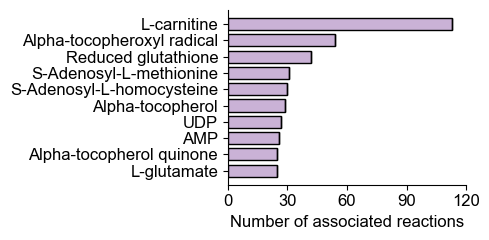

In [22]:
df = pd.concat(
    (
        df_metabolite_connectivity_table["cytosol"]["absolute"],
        df_metabolite_connectivity_table["extracellular space"]["absolute"],
    ),
    axis=1,
).head(10)
df.columns = ["cytosol", "extracellular space"]


columns_to_plot = ["cytosol", "extracellular space"]
df = df[columns_to_plot].copy()
colormaps_dict = {
    columns_to_plot[0]: mpl.colormaps["Paired"](8),
    columns_to_plot[1]: mpl.colormaps["Paired"](9),
}

mets_map = {
    "crn": "L-carnitine",
    "glu__L": "L-glutamate",
    "avite1qn": "Alpha-tocopherol quinone",
    "amp": "AMP",
    "udp": "UDP",
    "avite1": "Alpha-tocopherol",
    "ahcys__L": "S-Adenosyl-L-homocysteine",
    "amet__L": "S-Adenosyl-L-methionine",
    "gthrd": "Reduced glutathione",
    "avite1r": "Alpha-tocopheroxyl radical",
}
df.index = [mets_map[met] for met in df.index]


fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
sns.despine(fig)

barsize = 0.75
edgecolor = "black"
edgewidth = 1
padding = 2
offset = np.zeros(len(df.index))
df.index = df.index.astype(str)
df = df.loc[df.index[::-1]]
for idx, (label, series) in enumerate(df.items()):
    rects = ax.barh(
        series.index,
        series.values,
        height=barsize,
        left=offset,
        color=colormaps_dict.get(label),
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")

ax.set_xlabel("Number of associated reactions", fontdict={"size": "large"})
ax.set_xticks([0, 30, 60, 90, 120])

fig.tight_layout()
if save_figures:
    fig.savefig(
        results_path / f"Top10_wo_transporter.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else dpi,
    )